In [1]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Pretendard'  # Windows용
plt.rcParams['axes.unicode_minus'] = False     # 마이너스 깨짐 방지

# AB / CDE 따로 분류모델

In [2]:
import pandas as pd

# 파일 경로
file_path = "../../data/통합_train_데이터.parquet"
df = pd.read_parquet(file_path)

In [3]:
top_ab = ['할부금액_3M_R12M',
 '이용금액_할부_무이자_R12M',
 '이용건수_할부_무이자_R12M',
 '정상입금원금_B0M',
 '이용금액_오프라인_R6M',
 '정상청구원금_B0M',
 '이용금액_오프라인_R3M',
 '_1순위카드이용금액',
 '평잔_일시불_해외_6M',
 '승인거절건수_입력오류_R3M',
 '청구금액_R3M',
 '이용금액_일시불_R12M',
 '이용금액_할부_무이자_R3M',
 '이용금액_할부_무이자_R6M',
 '정상입금원금_B5M',
 '이용금액_할부_R12M',
 '마일_적립포인트_R3M',
 '정상청구원금_B2M',
 '포인트_마일리지_환산_B0M',
 '청구금액_B0',
 '정상입금원금_B2M',
 '할부건수_무이자_3M_R12M',
 '정상청구원금_B5M',
 '청구금액_R6M',
 '여유_숙박이용금액',
 '최대이용금액_일시불_R12M',
 '_1순위업종_이용금액',
 '잔액_할부_B0M',
 '할부금액_무이자_3M_R12M',
 '잔액_할부_무이자_B0M']

In [4]:
top_cde = ['이용금액_일시불_R3M',
 '이용금액_R3M_신용체크',
 '정상입금원금_B0M',
 '이용금액_오프라인_R6M',
 '정상청구원금_B0M',
 '이용건수_신용_R6M',
 '이용금액_오프라인_R3M',
 '이용건수_일시불_R12M',
 '_1순위카드이용금액',
 '이용금액_오프라인_B0M',
 '청구금액_R3M',
 '이용금액_일시불_R12M',
 '이용금액_R3M_신용',
 '정상입금원금_B5M',
 '이용건수_오프라인_B0M',
 '정상청구원금_B2M',
 '이용건수_신판_R12M',
 '청구금액_B0',
 '정상입금원금_B2M',
 '이용금액_일시불_B0M',
 '정상청구원금_B5M',
 '청구금액_R6M',
 '최대이용금액_일시불_R12M',
 '이용가맹점수',
 '이용건수_신용_R12M',
 '이용금액_일시불_R6M']

In [5]:
# 📌 PC1~PC5에서 반복적으로 중요한 변수:
pca_cols = ['CA이자율_할인전', 'CL이자율_할인전', 'RV_평균잔액_R3M', 'RV일시불이자율_할인전', 'RV최소결제비율', 'RV현금서비스이자율_할인전', '방문월수_앱_R6M', '방문일수_앱_B0M', '방문일수_앱_R6M', '방문횟수_앱_B0M', '방문후경과월_앱_R6M', '이용금액_R3M_신용', '이용금액_R3M_신용체크', '이용금액_일시불_B0M', '이용금액대', '일시불ONLY전환가능여부', '잔액_리볼빙일시불이월_B0M', '잔액_일시불_B0M', '잔액_일시불_B1M', '잔액_일시불_B2M', '잔액_카드론_B0M', '잔액_카드론_B1M', '잔액_카드론_B2M', '잔액_카드론_B3M', '잔액_카드론_B4M', '잔액_카드론_B5M', '정상청구원금_B0M', '정상청구원금_B2M', '정상청구원금_B5M', '청구금액_B0', '청구금액_R3M', '청구금액_R6M', '최종카드론_대출금액', '카드론이용금액_누적', '평잔_RV일시불_3M', '평잔_RV일시불_6M', '평잔_일시불_3M', '평잔_일시불_6M', '평잔_카드론_3M', '평잔_카드론_6M', '평잔_할부_3M', '홈페이지_금융건수_R3M', '홈페이지_금융건수_R6M', '홈페이지_선결제건수_R3M', '홈페이지_선결제건수_R6M']

In [6]:
selected_cols=(top_ab + top_cde + pca_cols)
selected_cols = list(dict.fromkeys(selected_cols))

In [7]:
# 기본적으로 필요한 컬럼
base_cols = ['ID', 'Segment']
all_selected_cols = list(set(base_cols + selected_cols))

In [8]:
def map_categorical_columns(df, verbose=True):
    """
    미리 정의된 매핑 기준에 따라 범주형 컬럼들을 수치형으로 변환합니다.
    처리 컬럼: 거주시도명, 연회비발생카드수_B0M, 한도증액횟수_R12M, 이용금액대,
              할인건수_R3M, 할인건수_B0M, 방문횟수_PC_R6M, 방문횟수_앱_R6M, 방문일수_PC_R6M
    """

    # 1. 거주시도명 → 수도권 여부
    capital_area = ['서울', '경기', '인천']
    if '거주시도명' in df.columns:
        df['거주시도명'] = df['거주시도명'].apply(lambda x: 1 if x in capital_area else 0)

    # 2. 연회비발생카드수_B0M
    mapping = {"0개": 0, "1개이상": 1}
    if '연회비발생카드수_B0M' in df.columns:
        df['연회비발생카드수_B0M'] = df['연회비발생카드수_B0M'].map(mapping).astype(int)
        if verbose: print("[연회비발생카드수_B0M] 인코딩 완료")

    # 3. 한도증액횟수_R12M
    mapping = {"0회": 0, "1회이상": 1}
    if '한도증액횟수_R12M' in df.columns:
        df['한도증액횟수_R12M'] = df['한도증액횟수_R12M'].map(mapping).astype(int)
        if verbose: print("[한도증액횟수_R12M] 인코딩 완료")

    # 4. 이용금액대 (중간값 기준: 만원 단위)
    mapping = {
        "09.미사용": 0,
        "05.10만원-": 5,
        "04.10만원+": 20,
        "03.30만원+": 40,
        "02.50만원+": 75,
        "01.100만원+": 150
    }
    if '이용금액대' in df.columns:
        df['이용금액대'] = df['이용금액대'].map(mapping)
        if verbose: print("[이용금액대] 중간값 인코딩 완료")

   # 5. 할인건수 인코딩
    discount_map = {
        "1회 이상": 1,
        "10회 이상": 10,
        "20회 이상": 20,
        "30회 이상": 30,
        "40회 이상": 40
    }
    for col in ['할인건수_R3M', '할인건수_B0M']:
        if col in df.columns:
            df[col] = df[col].map(discount_map).astype(int)
            if verbose: print(f"[{col}] 인코딩 완료")

    # 6. 방문횟수 및 방문일수 인코딩
    visit_map = {
        "1회 이상": 1,
        "10회 이상": 10,
        "20회 이상": 20,
        "30회 이상": 30,
        "40회 이상": 40,
        "50회 이상": 50,
        "60회 이상": 60,
        "70회 이상": 70,
        "80회 이상": 80
    }

    visit_cols = ['방문횟수_PC_R6M', '방문횟수_앱_R6M', '방문일수_PC_R6M']
    for col in visit_cols:
        if col in df.columns:
            df[col] = df[col].map(visit_map).astype(int)
            if verbose: print(f"[{col}] 인코딩 완료")

    return df

In [9]:
df = map_categorical_columns(df)

[연회비발생카드수_B0M] 인코딩 완료
[한도증액횟수_R12M] 인코딩 완료
[이용금액대] 중간값 인코딩 완료
[할인건수_R3M] 인코딩 완료
[할인건수_B0M] 인코딩 완료
[방문횟수_PC_R6M] 인코딩 완료
[방문횟수_앱_R6M] 인코딩 완료
[방문일수_PC_R6M] 인코딩 완료


In [10]:
ab_cols=(top_ab + pca_cols)
ab_cols = list(dict.fromkeys(ab_cols))

In [52]:
# 📌 Segment 라벨 기준: A/B → 1, C/D/E → 0
df['is_ab'] = df['Segment'].map(lambda x: 1 if x in ['A', 'B'] else 0)

# 👇 예시용 피처 컬럼 리스트 (사용 중인 걸로 대체하세요)
X = df[selected_cols]  # 선택된 피처들
y = df['is_ab']       # 이진 타겟

# ✅ Train / Validation 분리
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# ✅ 모델 후보 정의
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, confusion_matrix

models = {
#    "Logistic": LogisticRegression(max_iter=1000, class_weight='balanced'),
#    "RandomForest": RandomForestClassifier(n_estimators=100, class_weight='balanced'),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=(y == 0).sum() / (y == 1).sum()),
#    "LightGBM": LGBMClassifier(class_weight='balanced')
}

# ✅ 모델 학습 및 성능 평가
for name, model in models.items():
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    f1 = f1_score(y_val, preds)
    print(f"\n📌 [{name}] F1-score: {f1:.4f}")
    print(classification_report(y_val, preds))
    print(confusion_matrix(y_val, preds))


c:\Users\somee\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [15:09:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📌 [XGBoost] F1-score: 0.5591
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    479777
           1       0.43      0.82      0.56       223

    accuracy                           1.00    480000
   macro avg       0.71      0.91      0.78    480000
weighted avg       1.00      1.00      1.00    480000

[[479531    246]
 [    41    182]]


In [53]:
# A/B 추려진 데이터에서
ab_df = df[df['is_ab'] == 1].copy()

# 타겟: A=0, B=1
y_ab = ab_df['Segment'].map({'A': 0, 'B': 1})

# 전체 피처셋
X_ab_all = ab_df[ab_cols]

In [54]:
from xgboost import XGBClassifier
import pandas as pd

# 간단한 XGBoost 모델 학습
xgb_ab = XGBClassifier()
xgb_ab.fit(X_ab_all, y_ab)

# 중요도 추출
importances = pd.Series(xgb_ab.feature_importances_, index=X_ab_all.columns)
top_features_ab = importances.sort_values(ascending=False).head(20).index.tolist()

print("📌 A/B에서 가장 중요한 피처 Top 20:")
print(top_features_ab)

📌 A/B에서 가장 중요한 피처 Top 20:
['정상입금원금_B0M', '이용금액_할부_무이자_R12M', '홈페이지_선결제건수_R3M', '평잔_일시불_6M', '정상입금원금_B2M', '할부건수_무이자_3M_R12M', '이용금액_R3M_신용', 'RV현금서비스이자율_할인전', '잔액_리볼빙일시불이월_B0M', '잔액_카드론_B0M', '평잔_RV일시불_6M', '이용금액_일시불_R12M', '포인트_마일리지_환산_B0M', '잔액_할부_B0M', 'CA이자율_할인전', '할부금액_무이자_3M_R12M', '방문월수_앱_R6M', '평잔_할부_3M', '이용건수_할부_무이자_R12M', 'CL이자율_할인전']


In [55]:
# 선택된 피처만 사용
X_ab = X_ab_all[top_features_ab]

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X_train_ab, X_val_ab, y_train_ab, y_val_ab = train_test_split(X_ab, y_ab, stratify=y_ab, test_size=0.2, random_state=42)

model_ab_final = XGBClassifier()
model_ab_final.fit(X_train_ab, y_train_ab)
preds_ab = model_ab_final.predict(X_val_ab)

print(classification_report(y_val_ab, preds_ab))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       195
           1       0.86      0.66      0.75        29

    accuracy                           0.94       224
   macro avg       0.91      0.82      0.86       224
weighted avg       0.94      0.94      0.94       224



In [57]:
# ab_df를 X_ab와 같은 인덱스 기준으로 정렬
ab_df = ab_df.loc[X_ab.index].copy()

# 예측값 저장
ab_preds = model_ab_final.predict(X_ab)
ab_df['Segment_pred'] = ab_preds
ab_df['Segment_pred'] = ab_df['Segment_pred'].map({0: 'A', 1: 'B'})


In [58]:
cde_cols=(top_cde + pca_cols)
cde_cols = list(dict.fromkeys(cde_cols))

In [59]:
cols_needed = cde_cols + ['Segment', 'ID']
cde_df = df.loc[df['is_ab'] == 0, cols_needed]


In [60]:
# 타겟: Segment 문자 → 숫자 라벨
y_cde = cde_df['Segment'].map({'C': 0, 'D': 1, 'E': 2})

# 입력 피처
X_cde = cde_df[cde_cols]

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

# 학습용 데이터 분리
X_train_cde, X_val_cde, y_train_cde, y_val_cde = train_test_split(
    X_cde, y_cde, stratify=y_cde, test_size=0.2, random_state=42
)

# 다중 분류 모델 학습
model_cde = XGBClassifier(objective='multi:softmax', num_class=3, eval_metric='mlogloss')
model_cde.fit(X_train_cde, y_train_cde)

# 예측 및 평가
preds_cde = model_cde.predict(X_val_cde)
print(classification_report(y_val_cde, preds_cde))

              precision    recall  f1-score   support

           0       0.72      0.58      0.65     25518
           1       0.69      0.62      0.65     69848
           2       0.94      0.97      0.95    384411

    accuracy                           0.89    479777
   macro avg       0.78      0.72      0.75    479777
weighted avg       0.89      0.89      0.89    479777



In [62]:
# 전체 예측 (학습용 데이터 전체로)
cde_preds = model_cde.predict(X_cde)

# 숫자 → 문자 라벨 복원
cde_df['Segment_pred'] = pd.Series(cde_preds, index=X_cde.index)
cde_df['Segment_pred'] = cde_df['Segment_pred'].map({0: 'C', 1: 'D', 2: 'E'})

In [63]:
# ab_df는 이전에 Segment_pred가 포함된 A/B 예측 결과
final_df = pd.concat([ab_df, cde_df])

# ID 기준 정렬
final_df = final_df.sort_values('ID')

# 제출 파일 생성
submission = final_df[['ID', 'Segment_pred']].rename(columns={'Segment_pred': 'Segment'})
submission.to_csv('final_submission.csv', index=False)

In [83]:
test_df = pd.read_parquet("../../data/통합_test_데이터.parquet")
X_test = test_df[selected_cols].copy()  # 또는 ab_cols, cde_cols 기반

# ID 백업
test_ids = test_df['ID']

In [84]:
test_df[selected_cols]

,할부금액_3M_R12M,이용금액_할부_무이자_R12M,이용건수_할부_무이자_R12M,정상입금원금_B0M,이용금액_오프라인_R6M,정상청구원금_B0M,이용금액_오프라인_R3M,_1순위카드이용금액,평잔_일시불_해외_6M,승인거절건수_입력오류_R3M,...,평잔_RV일시불_6M,평잔_일시불_3M,평잔_일시불_6M,평잔_카드론_3M,평잔_카드론_6M,평잔_할부_3M,홈페이지_금융건수_R3M,홈페이지_금융건수_R6M,홈페이지_선결제건수_R3M,홈페이지_선결제건수_R6M
0,0,0,0,3680,24747,6495,19611,13852,384,0,...,0,3841,2933,0,0,0,0,0,0,0
1,10005,17396,23,8726,7896,9644,5489,11065,0,0,...,0,844,657,25782,31707,6514,0,0,0,0
2,21312,20756,9,11297,90530,11519,41402,27071,0,0,...,0,5606,6253,0,0,11865,0,0,0,0
3,5912,5136,0,1375,4683,1375,5343,4827,0,0,...,0,1510,819,0,0,704,0,0,0,0
4,13983,9884,8,3951,9920,3951,7567,8011,0,0,...,0,1373,979,0,0,3561,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
599996,0,0,0,205,2331,205,1178,1231,0,0,...,0,237,137,0,0,0,3,3,3,7
599997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
599998,1994,12509,4,0,89973,26308,44309,63592,240,0,...,0,17039,18108,0,0,1623,4,7,12,22


In [85]:
test_df = map_categorical_columns(test_df)

[연회비발생카드수_B0M] 인코딩 완료
[한도증액횟수_R12M] 인코딩 완료
[이용금액대] 중간값 인코딩 완료
[할인건수_R3M] 인코딩 완료
[할인건수_B0M] 인코딩 완료
[방문횟수_PC_R6M] 인코딩 완료
[방문횟수_앱_R6M] 인코딩 완료
[방문일수_PC_R6M] 인코딩 완료


In [10]:
import pandas as pd

# 파일 경로
file_path = "../../data/통합_train_데이터.parquet"
df = pd.read_parquet(file_path,columns=all_selected_cols)

In [11]:
df = map_categorical_columns(df)

[이용금액대] 중간값 인코딩 완료


In [11]:
ab_cols=(top_ab + pca_cols)
ab_cols = list(dict.fromkeys(ab_cols))

cde_cols=(top_cde + pca_cols)
cde_cols = list(dict.fromkeys(top_cde))

In [ ]:
# ✅ A/B vs C/D/E 이진 분류 학습
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

# 1. A/B vs CDE 타겟 생성
y_ab_vs_cde = df['Segment'].map(lambda x: 1 if x in ['A', 'B'] else 0)
X_ab_vs_cde = df[selected_cols]  # 🔄 변경: selected_cols 사용
X_ab_vs_cde = X_ab_vs_cde.loc[:, ~X_ab_vs_cde.columns.duplicated()]

# 2. 학습/검증 분리
tX, vX, ty, vy = train_test_split(X_ab_vs_cde, y_ab_vs_cde, test_size=0.2, random_state=42, stratify=y_ab_vs_cde)

# 3. 모델 학습
model_ab_vs_cde = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
model_ab_vs_cde.fit(tX, ty)


# ✅ A vs B 이진 분류 학습 (A/B에 해당하는 샘플만 사용)
ab_df = df[df['Segment'].isin(['A', 'B'])].copy()
X_ab = ab_df[top_ab + pca_cols]  # 🔄 변경: top_ab + pca_cols 사용
X_ab = X_ab.loc[:, ~X_ab.columns.duplicated()]
y_ab = ab_df['Segment'].map({'A': 0, 'B': 1})

model_ab_final = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
model_ab_final.fit(X_ab, y_ab)


# ✅ C vs D vs E 다중 분류 학습
cde_df = df[df['Segment'].isin(['C', 'D', 'E'])].copy()
X_cde = cde_df[top_cde + pca_cols]  # 🔄 변경: top_cde + pca_cols 사용
X_cde = X_cde.loc[:, ~X_cde.columns.duplicated()]
y_cde = cde_df['Segment'].map({'C': 0, 'D': 1, 'E': 2})

model_cde = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
model_cde.fit(X_cde, y_cde)


c:\Users\somee\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:56:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\somee\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:56:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [33]:
base_col = ["ID"]
selected_cols_test=(base_col + selected_cols)
selected_cols_test = list(dict.fromkeys(selected_cols_test))

In [34]:
import pandas as pd

# 파일 경로
file_path = "../../data/통합_test_데이터.parquet"
test_df = pd.read_parquet(file_path,columns=selected_cols_test)

In [35]:
test_df = map_categorical_columns(test_df)

[이용금액대] 중간값 인코딩 완료


In [36]:
test_df

,ID,할부금액_3M_R12M,이용금액_할부_무이자_R12M,이용건수_할부_무이자_R12M,정상입금원금_B0M,이용금액_오프라인_R6M,정상청구원금_B0M,이용금액_오프라인_R3M,_1순위카드이용금액,평잔_일시불_해외_6M,...,평잔_RV일시불_6M,평잔_일시불_3M,평잔_일시불_6M,평잔_카드론_3M,평잔_카드론_6M,평잔_할부_3M,홈페이지_금융건수_R3M,홈페이지_금융건수_R6M,홈페이지_선결제건수_R3M,홈페이지_선결제건수_R6M
0,TEST_00000,0,0,0,3680,24747,6495,19611,13852,384,...,0,3841,2933,0,0,0,0,0,0,0
1,TEST_00001,10005,17396,23,8726,7896,9644,5489,11065,0,...,0,844,657,25782,31707,6514,0,0,0,0
2,TEST_00002,21312,20756,9,11297,90530,11519,41402,27071,0,...,0,5606,6253,0,0,11865,0,0,0,0
3,TEST_00003,5912,5136,0,1375,4683,1375,5343,4827,0,...,0,1510,819,0,0,704,0,0,0,0
4,TEST_00004,13983,9884,8,3951,9920,3951,7567,8011,0,...,0,1373,979,0,0,3561,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599995,TEST_99995,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
599996,TEST_99996,0,0,0,205,2331,205,1178,1231,0,...,0,237,137,0,0,0,3,3,3,7
599997,TEST_99997,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
599998,TEST_99998,1994,12509,4,0,89973,26308,44309,63592,240,...,0,17039,18108,0,0,1623,4,7,12,22


In [38]:
# ✅ TEST 데이터 예측
# STEP 1: A/B vs C/D/E 분류
X_test_ab_vs_cde = test_df[selected_cols]
X_test_ab_vs_cde = X_test_ab_vs_cde.loc[:, ~X_test_ab_vs_cde.columns.duplicated()]
ab_proba_test = model_ab_vs_cde.predict_proba(X_test_ab_vs_cde)[:, 1]
ab_pred_test = (ab_proba_test >= 0.5).astype(int)

# STEP 2: 인덱스 분리
ab_idx = test_df.index[ab_pred_test == 1]
cde_idx = test_df.index[ab_pred_test == 0]

# STEP 3: A/B 예측
X_ab_test = test_df.loc[ab_idx, top_ab + pca_cols]
X_ab_test = X_ab_test.loc[:, ~X_ab_test.columns.duplicated()]
ab_result = model_ab_final.predict(X_ab_test)
ab_result = pd.Series(ab_result, index=ab_idx).map({0: 'A', 1: 'B'})

# STEP 4: C/D/E 예측
X_cde_test = test_df.loc[cde_idx, top_cde + pca_cols]
X_cde_test = X_cde_test.loc[:, ~X_cde_test.columns.duplicated()]
cde_result = model_cde.predict(X_cde_test)
cde_result = pd.Series(cde_result, index=cde_idx).map({0: 'C', 1: 'D', 2: 'E'})

# STEP 5: 결과 통합 및 저장
segment_pred = pd.concat([ab_result, cde_result]).sort_index()
submission = pd.DataFrame({'ID': test_df['ID'], 'Segment': segment_pred})
submission.to_csv('final_submission.csv', index=False)


In [43]:
# ID별로 예측된 Segment 종류 개수 확인
id_segment_counts = submission.groupby('ID')['Segment'].nunique()

# 2개 이상 Segment가 존재하는 ID 추출
conflicting_ids = id_segment_counts[id_segment_counts > 1]

print("⚠️ 세그먼트가 여러 개인 ID 수:", len(conflicting_ids))
print(conflicting_ids.head())

⚠️ 세그먼트가 여러 개인 ID 수: 15777
ID
TEST_00002    2
TEST_00008    2
TEST_00009    2
TEST_00012    2
TEST_00029    2
Name: Segment, dtype: int64


In [45]:
# ID별 Segment 최빈값(가장 많이 나온 세그먼트) 선택
majority_segment = (
    submission.groupby('ID')['Segment']
    .agg(lambda x: x.value_counts().idxmax())
    .reset_index()
)

majority_segment.columns = ['ID', 'Segment']

In [46]:
majority_segment.to_csv("submission_majority_segment.csv", index=False)

In [47]:
# ID별 Segment 분포 비율 보기
segment_ratio = (
    submission.groupby(['ID', 'Segment']).size()
    .div(6)  # 6개씩 있다고 가정
    .unstack(fill_value=0)
)

print(segment_ratio.head())

Segment       A    B    C         D         E
ID                                           
TEST_00000  0.0  0.0  0.0  0.000000  1.000000
TEST_00001  0.0  0.0  0.0  0.000000  1.000000
TEST_00002  0.0  0.0  0.0  0.333333  0.666667
TEST_00003  0.0  0.0  0.0  0.000000  1.000000
TEST_00004  0.0  0.0  0.0  0.000000  1.000000


📊 [AB vs CDE] Classification Report
              precision    recall  f1-score   support

         CDE       1.00      1.00      1.00    479777
          AB       0.33      0.34      0.33       223

    accuracy                           1.00    480000
   macro avg       0.67      0.67      0.67    480000
weighted avg       1.00      1.00      1.00    480000



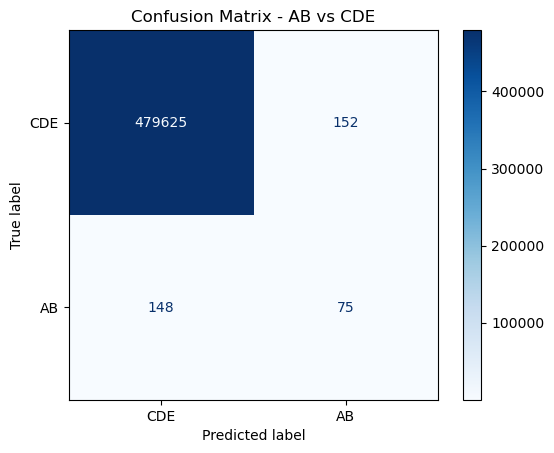

In [51]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 예측
y_pred_ab_vs_cde = model_ab_vs_cde.predict(vX)

# 성능 보고서
print("📊 [AB vs CDE] Classification Report")
print(classification_report(vy, y_pred_ab_vs_cde, target_names=['CDE', 'AB']))

# 혼동 행렬 시각화
cm = confusion_matrix(vy, y_pred_ab_vs_cde)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['CDE', 'AB'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - AB vs CDE")
plt.show()


c:\Users\somee\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:18:19] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


📊 [A vs B] Classification Report
              precision    recall  f1-score   support

           A       0.96      0.98      0.97       195
           B       0.88      0.72      0.79        29

    accuracy                           0.95       224
   macro avg       0.92      0.85      0.88       224
weighted avg       0.95      0.95      0.95       224



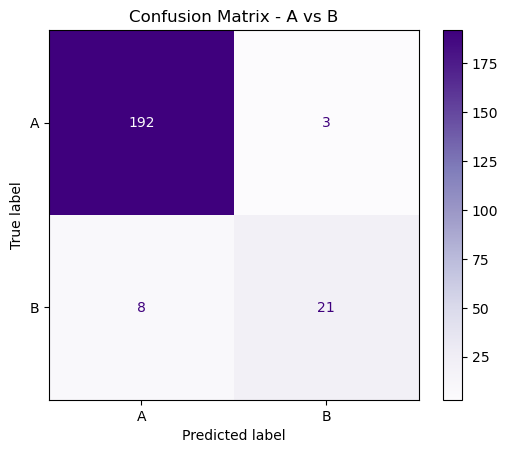

In [52]:
# 학습/검증 나누기
X_ab_train, X_ab_val, y_ab_train, y_ab_val = train_test_split(X_ab, y_ab, test_size=0.2, random_state=42, stratify=y_ab)

# 모델 재학습 (선택사항)
model_ab_final.fit(X_ab_train, y_ab_train)

# 예측 및 평가
y_pred_ab = model_ab_final.predict(X_ab_val)

print("📊 [A vs B] Classification Report")
print(classification_report(y_ab_val, y_pred_ab, target_names=['A', 'B']))

cm_ab = confusion_matrix(y_ab_val, y_pred_ab)
ConfusionMatrixDisplay(confusion_matrix=cm_ab, display_labels=['A', 'B']).plot(cmap='Purples')
plt.title("Confusion Matrix - A vs B")
plt.show()

c:\Users\somee\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:18:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


📊 [C vs D vs E] Classification Report
              precision    recall  f1-score   support

           C       0.72      0.58      0.65     25518
           D       0.69      0.62      0.65     69848
           E       0.94      0.97      0.95    384411

    accuracy                           0.89    479777
   macro avg       0.78      0.72      0.75    479777
weighted avg       0.89      0.89      0.89    479777



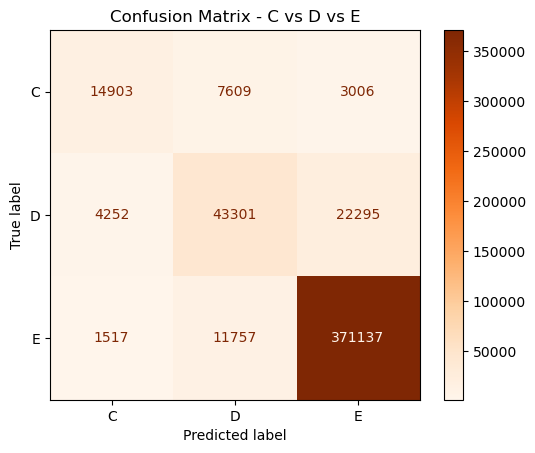

In [53]:
# 검증셋 분리
X_cde_train, X_cde_val, y_cde_train, y_cde_val = train_test_split(X_cde, y_cde, test_size=0.2, random_state=42, stratify=y_cde)

# 모델 재학습 (선택)
model_cde.fit(X_cde_train, y_cde_train)

# 예측
y_pred_cde = model_cde.predict(X_cde_val)

print("📊 [C vs D vs E] Classification Report")
print(classification_report(y_cde_val, y_pred_cde, target_names=['C', 'D', 'E']))

cm_cde = confusion_matrix(y_cde_val, y_pred_cde)
ConfusionMatrixDisplay(confusion_matrix=cm_cde, display_labels=['C', 'D', 'E']).plot(cmap='Oranges')
plt.title("Confusion Matrix - C vs D vs E")
plt.show()

- AB / CDE 이진 분류에서도 AB수가 너무 적어 거의 무시하는경향

# 오버샘플링 시도

### SMOTE

c:\Users\somee\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:24:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


📊 [AB vs CDE] Classification Report (SMOTE 적용)
              precision    recall  f1-score   support

         CDE       1.00      1.00      1.00    479777
          AB       0.44      0.80      0.57       223

    accuracy                           1.00    480000
   macro avg       0.72      0.90      0.79    480000
weighted avg       1.00      1.00      1.00    480000



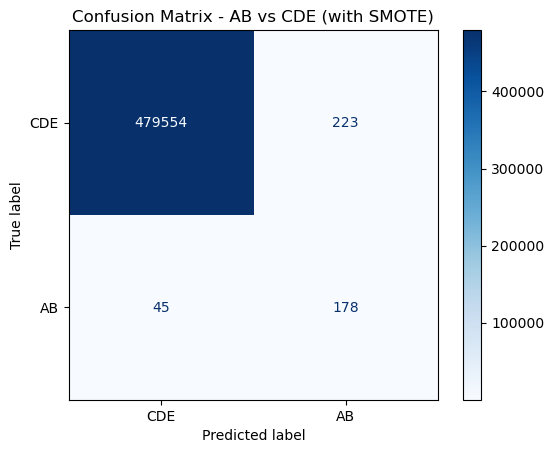

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

# 1. 타겟 정의
y_ab_vs_cde = df['Segment'].map(lambda x: 1 if x in ['A', 'B'] else 0)
X_ab_vs_cde = df[selected_cols]
X_ab_vs_cde = X_ab_vs_cde.loc[:, ~X_ab_vs_cde.columns.duplicated()]

# 2. 학습/검증 분할
tX, vX, ty, vy = train_test_split(X_ab_vs_cde, y_ab_vs_cde, test_size=0.2, random_state=42, stratify=y_ab_vs_cde)

# 3. ✅ SMOTE 오버샘플링
smote = SMOTE(random_state=42)
tX_resampled, ty_resampled = smote.fit_resample(tX, ty)

# 4. 모델 학습
model_ab_vs_cde = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
model_ab_vs_cde.fit(tX_resampled, ty_resampled)

# 5. 검증 예측
ab_proba_val = model_ab_vs_cde.predict_proba(vX)[:, 1]
ab_pred_val = (ab_proba_val >= 0.5).astype(int)

# 6. 성능 평가
print("📊 [AB vs CDE] Classification Report (SMOTE 적용)")
print(classification_report(vy, ab_pred_val, target_names=['CDE', 'AB']))

# 7. 혼동 행렬
cm = confusion_matrix(vy, ab_pred_val)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['CDE', 'AB'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - AB vs CDE (with SMOTE)")
plt.show()

| 지표               | SMOTE 전 | SMOTE 후    |
| ---------------- | ------- | ---------- |
| **AB Recall**    | 0.34    | **0.80** ✅ |
| **AB Precision** | 0.33    | **0.44** ✅ |
| **AB F1-score**  | 0.33    | **0.57** ✅ |
| **CDE F1-score** | 1.00    | 1.00       |
| **Accuracy**     | ≈1.00   | 1.00       |

Recall 0.80 → AB 고객 10명 중 8명 찾음

언더샘플링 후 클래스 분포:
 Segment
0    1116
1    1116
Name: count, dtype: int64


c:\Users\somee\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:26:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


📊 [AB vs CDE] Classification Report (언더샘플링)
              precision    recall  f1-score   support

         CDE       1.00      0.98      0.99       224
          AB       0.98      1.00      0.99       223

    accuracy                           0.99       447
   macro avg       0.99      0.99      0.99       447
weighted avg       0.99      0.99      0.99       447



c:\Users\somee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 50616 (\N{HANGUL SYLLABLE EON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\somee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 45908 (\N{HANGUL SYLLABLE DEO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\somee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49368 (\N{HANGUL SYLLABLE SAEM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\somee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 54540 (\N{HANGUL SYLLABLE PEUL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\somee\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 47553 (\N{HANGUL SYLLABLE RING}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(byt

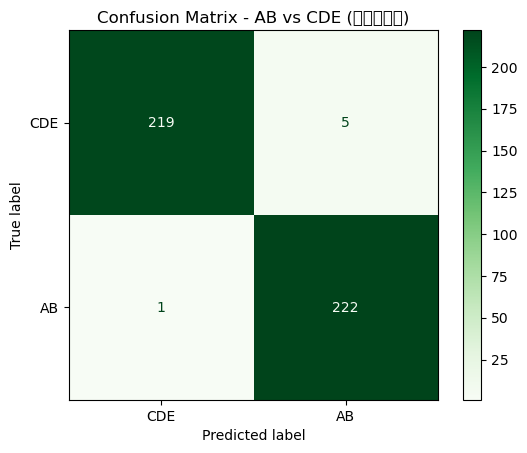

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# 1. 타겟 정의
y_ab_vs_cde = df['Segment'].map(lambda x: 1 if x in ['A', 'B'] else 0)
X_ab_vs_cde = df[selected_cols]
X_ab_vs_cde = X_ab_vs_cde.loc[:, ~X_ab_vs_cde.columns.duplicated()]

# 2. 언더샘플링 적용
rus = RandomUnderSampler(random_state=42)
X_under, y_under = rus.fit_resample(X_ab_vs_cde, y_ab_vs_cde)

# 확인
print("언더샘플링 후 클래스 분포:\n", pd.Series(y_under).value_counts())

# 3. 학습/검증 분할
tX, vX, ty, vy = train_test_split(X_under, y_under, test_size=0.2, random_state=42, stratify=y_under)

# 4. 모델 학습
model_ab_vs_cde = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
model_ab_vs_cde.fit(tX, ty)

# 5. 예측 및 평가
y_pred = model_ab_vs_cde.predict(vX)
print("📊 [AB vs CDE] Classification Report (언더샘플링)")
print(classification_report(vy, y_pred, target_names=["CDE", "AB"]))

# 6. 혼동 행렬 시각화
cm = confusion_matrix(vy, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["CDE", "AB"]).plot(cmap='Greens')
plt.title("Confusion Matrix - AB vs CDE (언더샘플링)")
plt.show()

- 언언더샘플링 결과: F1 0.99 ← 검증셋이 너무 작아 신뢰 ↓

In [13]:
# 기준년월 기준으로 정렬한 뒤
df_sorted = df.sort_values(['ID', '기준년월'], ascending=[True, False])

# ID별로 가장 마지막 월의 행만 남김
df_latest = df_sorted.drop_duplicates(subset='ID', keep='first').reset_index(drop=True)

In [14]:
# 📌 필요한 라이브러리
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek
import pandas as pd
import time


In [15]:
# 🎯 이진 분류 타겟 정의 (A/B = 1, C/D/E = 0)
y_ab_vs_cde = df_latest['Segment'].map(lambda x: 1 if x in ['A', 'B'] else 0)

# 🎯 사용 피처: selected_cols (중복 컬럼 제거)
X_ab_vs_cde = df_latest[selected_cols].copy()
X_ab_vs_cde = X_ab_vs_cde.loc[:, ~X_ab_vs_cde.columns.duplicated()]

In [16]:
def train_evaluate_after_split(X, y, sampler, title):
    print(f"\n⏳ [{title}] 시작합니다...")
    start = time.time()

    # 1️⃣ train/val 분리 (val은 원본 분포 유지)
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # 2️⃣ train에만 리샘플링 적용
    X_res, y_res = sampler.fit_resample(X_train, y_train)

    print("📊 val 클래스 분포 확인:")
    print(pd.Series(y_val).value_counts())

    # 3️⃣ XGBoost 분류기 학습
    model = XGBClassifier(
        tree_method='gpu_hist',  # 코랩 GPU 사용 가능
        predictor='gpu_predictor',
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )
    model.fit(X_res, y_res)

    # 4️⃣ 검증 데이터 평가
    y_pred = model.predict(X_val)
    print(f"\n📊 [{title}] Classification Report (val: 원본 유지)")
    print(classification_report(y_val, y_pred, target_names=['CDE', 'AB']))

    end = time.time()
    print(f"✅ [{title}] 완료 (소요 시간: {end - start:.2f}초)")

In [17]:
train_evaluate_after_split(X_ab_vs_cde, y_ab_vs_cde, SMOTE(random_state=42), "SMOTE")
#train_evaluate_after_split(X_ab_vs_cde, y_ab_vs_cde, SMOTEENN(random_state=42), "SMOTEENN")
train_evaluate_after_split(X_ab_vs_cde, y_ab_vs_cde, SMOTETomek(random_state=42), "SMOTETomek")


⏳ [SMOTE] 시작합니다...
📊 val 클래스 분포 확인:
Segment
0    79963
1       37
Name: count, dtype: int64


c:\Users\somee\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:45:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\somee\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:45:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\somee\anaconda3\Lib\site-packages\xgboost\core.py:2676: UserWarning: [19:45:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.s


📊 [SMOTE] Classification Report (val: 원본 유지)
              precision    recall  f1-score   support

         CDE       1.00      1.00      1.00     79963
          AB       0.24      0.35      0.29        37

    accuracy                           1.00     80000
   macro avg       0.62      0.68      0.64     80000
weighted avg       1.00      1.00      1.00     80000

✅ [SMOTE] 완료 (소요 시간: 5.66초)

⏳ [SMOTETomek] 시작합니다...
📊 val 클래스 분포 확인:
Segment
0    79963
1       37
Name: count, dtype: int64


c:\Users\somee\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:53:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\somee\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:53:40] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📊 [SMOTETomek] Classification Report (val: 원본 유지)
              precision    recall  f1-score   support

         CDE       1.00      1.00      1.00     79963
          AB       0.24      0.35      0.29        37

    accuracy                           1.00     80000
   macro avg       0.62      0.68      0.64     80000
weighted avg       1.00      1.00      1.00     80000

✅ [SMOTETomek] 완료 (소요 시간: 466.31초)


c:\Users\somee\anaconda3\Lib\site-packages\xgboost\core.py:2676: UserWarning: [19:53:42] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


- 성능상 진행 X (안돌아간다.. + 
SMOTEENN - 보강 + 노이즈제거
SMOTETomek - 보강 + 경계제거)
- 거의 동일성능 but 훨씬느림 -> 최종 : SMOTE 확정

# E vs 나머지 분류모델

In [18]:
# ✅ 타겟 정의: E vs 나머지
y_e_vs_rest = df['Segment'].map(lambda x: 1 if x == 'E' else 0)

# ✅ 피처: selected_cols 기반
X_e_vs_rest = df[selected_cols].copy()
X_e_vs_rest = X_e_vs_rest.loc[:, ~X_e_vs_rest.columns.duplicated()]

In [19]:
def train_evaluate_e_vs_rest(X, y, sampler, title):
    print(f"\n⏳ [{title}] 시작합니다...")
    start = time.time()

    # 원본 기준 분리
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # train만 리샘플링
    X_res, y_res = sampler.fit_resample(X_train, y_train)

    # XGBoost 학습
    model = XGBClassifier(
        tree_method='hist',
        device='cuda',
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )
    model.fit(X_res, y_res)

    # 예측 및 평가
    y_pred = model.predict(X_val)
    print(f"\n📊 [{title}] Classification Report (E vs 나머지)")
    print(classification_report(y_val, y_pred, target_names=['Not-E', 'E']))

    end = time.time()
    print(f"✅ [{title}] 완료 (소요 시간: {end - start:.2f}초)")
    
    return model

In [20]:
model_e_vs_rest = train_evaluate_e_vs_rest(
    X_e_vs_rest,
    y_e_vs_rest,
    SMOTE(random_state=42),
    "E vs Others (SMOTE)"
)


⏳ [E vs Others (SMOTE)] 시작합니다...


c:\Users\somee\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:00:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📊 [E vs Others (SMOTE)] Classification Report (E vs 나머지)
              precision    recall  f1-score   support

       Not-E       0.77      0.81      0.79     95590
           E       0.95      0.94      0.95    384410

    accuracy                           0.91    480000
   macro avg       0.86      0.88      0.87    480000
weighted avg       0.92      0.91      0.92    480000

✅ [E vs Others (SMOTE)] 완료 (소요 시간: 183.13초)


### 나머지 AB / CD 분류

In [28]:
# 🎯 E 제외
ab_cd_df = df_latest[df_latest['Segment'].isin(['A', 'B', 'C', 'D'])].copy()

# 🎯 타겟: A/B = 1, C/D = 0
y_ab_vs_cd = ab_cd_df['Segment'].map(lambda x: 1 if x in ['A', 'B'] else 0)

# 🎯 피처: selected_cols
X_ab_vs_cd = ab_cd_df[selected_cols].copy()
X_ab_vs_cd = X_ab_vs_cd.loc[:, ~X_ab_vs_cd.columns.duplicated()]

In [29]:
def train_evaluate_ab_vs_cd(X, y, sampler=None, title="AB vs CD"):
    print(f"\n⏳ [{title}] 시작합니다...")
    start = time.time()

    # 1️⃣ 분리
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )

    # 2️⃣ 리샘플링 (옵션)
    if sampler:
        X_train, y_train = sampler.fit_resample(X_train, y_train)

    # 3️⃣ 모델 학습
    model = XGBClassifier(
        tree_method='hist',
        device='cuda',
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )
    model.fit(X_train, y_train)

    # 4️⃣ 평가
    y_pred = model.predict(X_val)
    print(f"\n📊 [{title}] Classification Report (AB vs CD)")
    print(classification_report(y_val, y_pred, target_names=['C/D', 'A/B']))

    end = time.time()
    print(f"✅ [{title}] 완료 (소요 시간: {end - start:.2f}초)")
    return model


In [30]:
# SMOTE 없이
model_ab_vs_cd_noresample = train_evaluate_ab_vs_cd(
    X_ab_vs_cd,
    y_ab_vs_cd,
    sampler=None,
    title="AB vs CD (No Resampling)"
)

# SMOTE 적용
from imblearn.over_sampling import SMOTE

model_ab_vs_cd_smote = train_evaluate_ab_vs_cd(
    X_ab_vs_cd,
    y_ab_vs_cd,
    sampler=SMOTE(random_state=42),
    title="AB vs CD (SMOTE)"
)


⏳ [AB vs CD (No Resampling)] 시작합니다...


c:\Users\somee\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:02:55] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📊 [AB vs CD (No Resampling)] Classification Report (AB vs CD)
              precision    recall  f1-score   support

         C/D       1.00      1.00      1.00     15895
         A/B       0.50      0.11      0.18        37

    accuracy                           1.00     15932
   macro avg       0.75      0.55      0.59     15932
weighted avg       1.00      1.00      1.00     15932

✅ [AB vs CD (No Resampling)] 완료 (소요 시간: 0.83초)

⏳ [AB vs CD (SMOTE)] 시작합니다...


c:\Users\somee\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:02:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📊 [AB vs CD (SMOTE)] Classification Report (AB vs CD)
              precision    recall  f1-score   support

         C/D       1.00      1.00      1.00     15895
         A/B       0.38      0.38      0.38        37

    accuracy                           1.00     15932
   macro avg       0.69      0.69      0.69     15932
weighted avg       1.00      1.00      1.00     15932

✅ [AB vs CD (SMOTE)] 완료 (소요 시간: 1.26초)


In [31]:
ab_df = df_latest[df_latest['Segment'].isin(['A', 'B'])].copy()
y_ab = ab_df['Segment'].map({'A': 0, 'B': 1})
X_ab = ab_df[top_ab + pca_cols].copy()
X_ab = X_ab.loc[:, ~X_ab.columns.duplicated()]

model_a_vs_b = XGBClassifier(
    tree_method='hist', device='cuda',
    use_label_encoder=False, eval_metric='logloss', random_state=42
)
model_a_vs_b.fit(X_ab, y_ab)

c:\Users\somee\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:04:18] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [32]:
cd_df = df_latest[df_latest['Segment'].isin(['C', 'D'])].copy()
y_cd = cd_df['Segment'].map({'C': 0, 'D': 1})
X_cd = cd_df[top_cde + pca_cols].copy()
X_cd = X_cd.loc[:, ~X_cd.columns.duplicated()]

model_c_vs_d = XGBClassifier(
    tree_method='hist', device='cuda',
    use_label_encoder=False, eval_metric='logloss', random_state=42
)
model_c_vs_d.fit(X_cd, y_cd)


c:\Users\somee\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:04:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device='cuda', early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [36]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

def evaluate_model(model, X_val, y_val, labels, title):
    # 예측
    y_pred = model.predict(X_val)

    # 📊 성능지표
    print(f"\n📌 [{title}] Classification Report")
    print(classification_report(y_val, y_pred, target_names=labels))

    # 🔲 혼돈행렬
    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues")
    plt.title(f"{title} - Confusion Matrix")
    plt.show()


📌 [E vs Others] Classification Report
              precision    recall  f1-score   support

      Others       0.78      0.82      0.80    477948
           E       0.95      0.94      0.95   1922052

    accuracy                           0.92   2400000
   macro avg       0.87      0.88      0.87   2400000
weighted avg       0.92      0.92      0.92   2400000



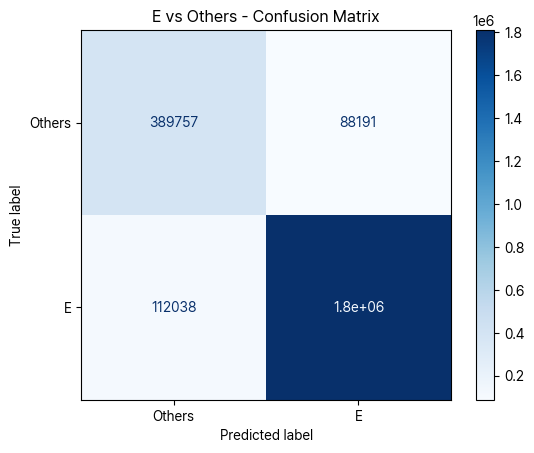


📌 [A/B vs C/D] Classification Report
              precision    recall  f1-score   support

         C/D       1.00      1.00      1.00     79472
         A/B       0.88      0.88      0.88       186

    accuracy                           1.00     79658
   macro avg       0.94      0.94      0.94     79658
weighted avg       1.00      1.00      1.00     79658



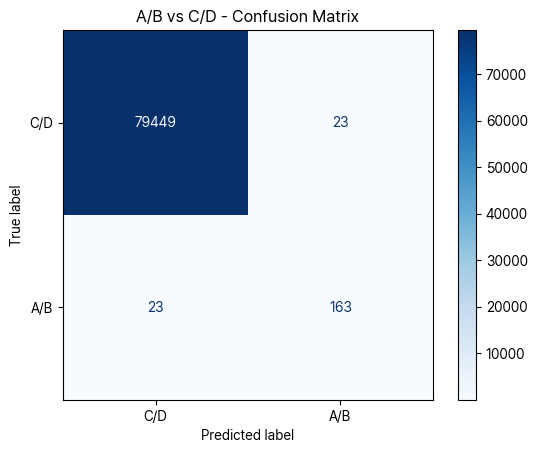


📌 [A vs B] Classification Report
              precision    recall  f1-score   support

           A       1.00      1.00      1.00       162
           B       1.00      1.00      1.00        24

    accuracy                           1.00       186
   macro avg       1.00      1.00      1.00       186
weighted avg       1.00      1.00      1.00       186



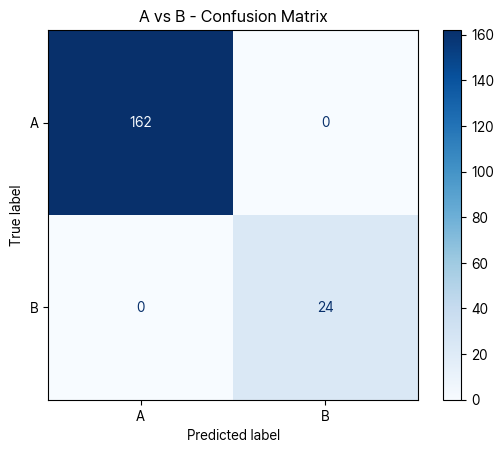


📌 [C vs D] Classification Report
              precision    recall  f1-score   support

           C       0.87      0.69      0.77     21265
           D       0.90      0.96      0.93     58207

    accuracy                           0.89     79472
   macro avg       0.88      0.83      0.85     79472
weighted avg       0.89      0.89      0.89     79472



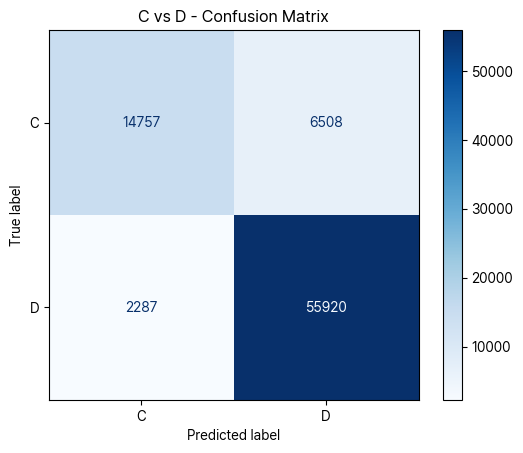

In [37]:
evaluate_model(
    model_e_vs_rest,
    X_e_vs_rest,
    y_e_vs_rest,
    labels=["Others", "E"],
    title="E vs Others"
)
evaluate_model(
    model_ab_vs_cd_smote,
    X_ab_vs_cd,
    y_ab_vs_cd,
    labels=["C/D", "A/B"],
    title="A/B vs C/D"
)
evaluate_model(
    model_a_vs_b,
    X_ab,
    y_ab,
    labels=["A", "B"],
    title="A vs B"
)
evaluate_model(
    model_c_vs_d,
    X_cd,
    y_cd,
    labels=["C", "D"],
    title="C vs D"
)

In [38]:
abcd_df = df_latest[df_latest['Segment'].isin(['A', 'B', 'C', 'D'])].copy()
y_abcd_true = abcd_df['Segment']

# 예측은 아래와 같이 단계적으로 조합

In [54]:
e_df = df.copy()

In [59]:
y_true_final = df['Segment']

In [55]:
# 🎯 1. AB vs CD 분류
X_abcd = df[selected_cols].copy()
X_abcd = X_abcd.loc[:, ~X_abcd.columns.duplicated()]
ab_cd_pred = model_ab_vs_cd_smote.predict(X_abcd)

# 🎯 인덱스 분리
idx_ab = df.index[ab_cd_pred == 1]
idx_cd = df.index[ab_cd_pred == 0]

# 🎯 2. A vs B
X_ab = df.loc[idx_ab, top_ab + pca_cols]
X_ab = X_ab.loc[:, ~X_ab.columns.duplicated()]
a_b_pred = model_a_vs_b.predict(X_ab)
a_b_pred = pd.Series(a_b_pred, index=idx_ab).map({0: 'A', 1: 'B'})

# 🎯 3. C vs D
X_cd = df.loc[idx_cd, top_cde + pca_cols]
X_cd = X_cd.loc[:, ~X_cd.columns.duplicated()]
c_d_pred = model_c_vs_d.predict(X_cd)
c_d_pred = pd.Series(c_d_pred, index=idx_cd).map({0: 'C', 1: 'D'})

# 🎯 4. A/B/C/D 최종 병합
abcd_pred = pd.concat([a_b_pred, c_d_pred]).sort_index()


In [56]:
# 🎯 1. E vs Others 예측
X_e_vs_rest = e_df[selected_cols].copy()
X_e_vs_rest = X_e_vs_rest.loc[:, ~X_e_vs_rest.columns.duplicated()]

e_vs_others_pred = model_e_vs_rest.predict(X_e_vs_rest)

# 🎯 2. 인덱스 분리
idx_e = e_df.index[e_vs_others_pred == 1]
idx_rest = e_df.index[e_vs_others_pred == 0]

# 🎯 3. E로 확정된 고객
e_pred = pd.Series('E', index=idx_e)

# 🎯 4. E 아닌 고객 → A/B/C/D 분류
X_rest = e_df.loc[idx_rest, selected_cols].copy()
X_rest = X_rest.loc[:, ~X_rest.columns.duplicated()]

# 4-1. AB vs CD 분류
ab_cd_pred_rest = model_ab_vs_cd_smote.predict(X_rest)
idx_ab_rest = X_rest.index[ab_cd_pred_rest == 1]
idx_cd_rest = X_rest.index[ab_cd_pred_rest == 0]

# 4-2. A vs B 분류
X_ab_rest = X_rest.loc[idx_ab_rest, top_ab + pca_cols].copy()
X_ab_rest = X_ab_rest.loc[:, ~X_ab_rest.columns.duplicated()]
a_b_pred_rest = model_a_vs_b.predict(X_ab_rest)
a_b_pred_rest = pd.Series(a_b_pred_rest, index=idx_ab_rest).map({0: 'A', 1: 'B'})

# 4-3. C vs D 분류
X_cd_rest = X_rest.loc[idx_cd_rest, top_cde + pca_cols].copy()
X_cd_rest = X_cd_rest.loc[:, ~X_cd_rest.columns.duplicated()]
c_d_pred_rest = model_c_vs_d.predict(X_cd_rest)
c_d_pred_rest = pd.Series(c_d_pred_rest, index=idx_cd_rest).map({0: 'C', 1: 'D'})

# 🎯 5. E 아닌 고객 → A/B/C/D 결과 병합
abcd_rest_pred = pd.concat([a_b_pred_rest, c_d_pred_rest])

# 🎯 6. 기존 abcd_df 예측값과 E 분류 병합
final_pred = pd.concat([abcd_pred, abcd_rest_pred, e_pred]).sort_index()


In [62]:
# 인덱스 중복 및 정렬 처리
final_pred = final_pred[~final_pred.index.duplicated(keep='first')]
final_pred = final_pred.sort_index()

y_true_final = y_true_final.loc[final_pred.index]

# 이후 평가 진행
print(classification_report(y_true_final, final_pred, labels=["A", "B", "C", "D", "E"]))


              precision    recall  f1-score   support

           A       0.22      0.58      0.32       972
           B       0.53      0.38      0.44       144
           C       0.50      0.64      0.56    127590
           D       0.21      0.76      0.33    349242
           E       0.95      0.47      0.63   1922052

    accuracy                           0.52   2400000
   macro avg       0.48      0.57      0.45   2400000
weighted avg       0.82      0.52      0.58   2400000



📌 [A/B/C/D] Classification Report
              precision    recall  f1-score   support

           A       0.86      0.86      0.86       162
           B       0.96      1.00      0.98        24
           C       0.86      0.69      0.77     21265
           D       0.90      0.96      0.93     58207

    accuracy                           0.89     79658
   macro avg       0.90      0.88      0.88     79658
weighted avg       0.89      0.89      0.88     79658



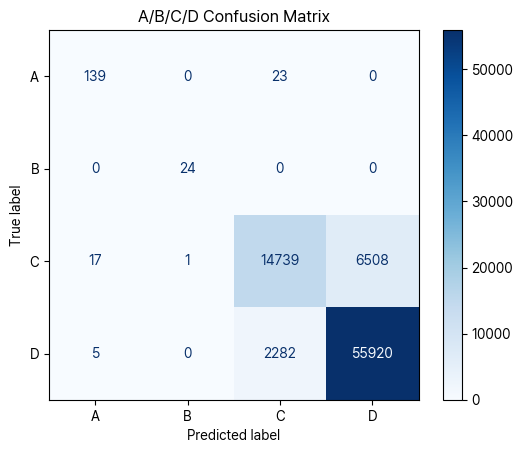

In [40]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print("📌 [A/B/C/D] Classification Report")
print(classification_report(y_abcd_true, abcd_pred, labels=['A', 'B', 'C', 'D']))

cm = confusion_matrix(y_abcd_true, abcd_pred, labels=['A', 'B', 'C', 'D'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['A', 'B', 'C', 'D'])
disp.plot(cmap='Blues')
plt.title("A/B/C/D Confusion Matrix")
plt.show()


### C / D 구분전략

In [43]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import time

def train_and_evaluate_c_vs_d(X, y, title="Model", threshold=None, sample_strategy=None, weight=False):
    X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
    
    # 리샘플링
    if sample_strategy == "SMOTE":
        X_train, y_train = SMOTE(random_state=42).fit_resample(X_train, y_train)

    # 가중치
    scale_pos_weight = None
    if weight:
        scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

    model = XGBClassifier(
        tree_method="hist", device="cuda",
        use_label_encoder=False, eval_metric="logloss",
        random_state=42,
        scale_pos_weight=scale_pos_weight
    )

    start = time.time()
    model.fit(X_train, y_train)
    elapsed = time.time() - start

    # 예측
    if threshold:
        proba = model.predict_proba(X_val)[:, 1]
        y_pred = (proba > threshold).astype(int)
    else:
        y_pred = model.predict(X_val)

    # 출력
    print(f"\n📌 [{title}] (소요 시간: {elapsed:.2f}초)")
    print(classification_report(y_val, y_pred, target_names=["C", "D"]))

    cm = confusion_matrix(y_val, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=["C", "D"]).plot(cmap="Blues")
    plt.title(f"{title} - Confusion Matrix")
    plt.show()

    return model


c:\Users\somee\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:15:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📌 [C vs D - 기본 모델] (소요 시간: 2.01초)
              precision    recall  f1-score   support

           C       0.77      0.62      0.69     25518
           D       0.87      0.93      0.90     69849

    accuracy                           0.85     95367
   macro avg       0.82      0.78      0.80     95367
weighted avg       0.85      0.85      0.84     95367



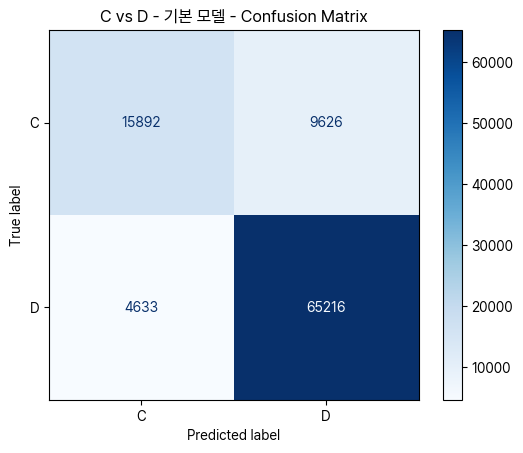

c:\Users\somee\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:15:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📌 [C vs D - 가중치 적용] (소요 시간: 1.83초)
              precision    recall  f1-score   support

           C       0.64      0.80      0.71     25518
           D       0.92      0.84      0.88     69849

    accuracy                           0.83     95367
   macro avg       0.78      0.82      0.80     95367
weighted avg       0.85      0.83      0.83     95367



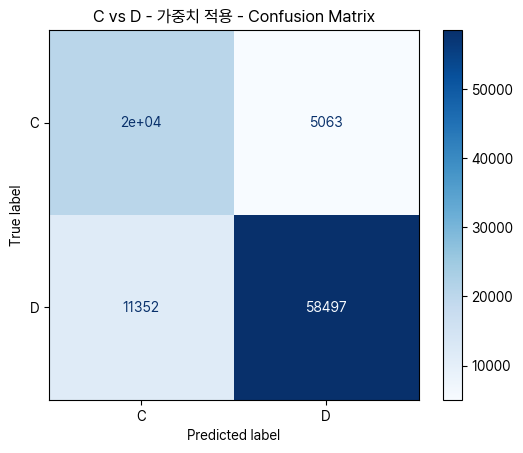

c:\Users\somee\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:15:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📌 [C vs D - SMOTE 적용] (소요 시간: 2.35초)
              precision    recall  f1-score   support

           C       0.72      0.69      0.70     25518
           D       0.89      0.90      0.89     69849

    accuracy                           0.84     95367
   macro avg       0.80      0.79      0.80     95367
weighted avg       0.84      0.84      0.84     95367



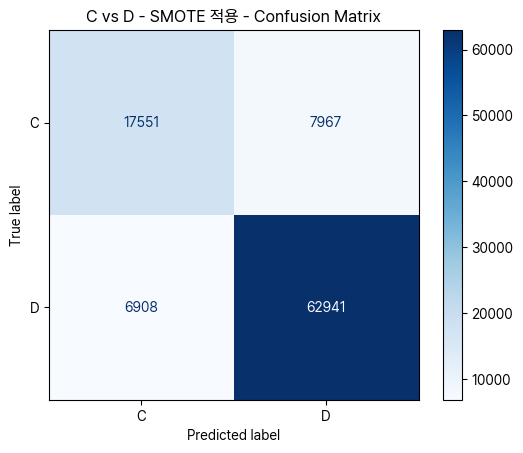

c:\Users\somee\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:15:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📌 [C vs D - Threshold 0.6] (소요 시간: 1.76초)
              precision    recall  f1-score   support

           C       0.72      0.70      0.71     25518
           D       0.89      0.90      0.90     69849

    accuracy                           0.85     95367
   macro avg       0.81      0.80      0.80     95367
weighted avg       0.85      0.85      0.85     95367



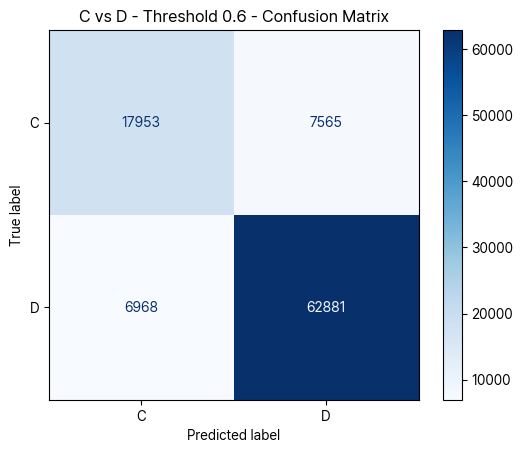

In [44]:
# 데이터 준비
cd_df = df[df['Segment'].isin(['C', 'D'])].copy()
y_cd = cd_df['Segment'].map({'C': 0, 'D': 1})
X_cd = cd_df[top_cde + pca_cols].copy()
X_cd = X_cd.loc[:, ~X_cd.columns.duplicated()]

# 1. 기본 모델
model_cvd_base = train_and_evaluate_c_vs_d(X_cd, y_cd, title="C vs D - 기본 모델")

# 2. 가중치 적용
model_cvd_weight = train_and_evaluate_c_vs_d(X_cd, y_cd, title="C vs D - 가중치 적용", weight=True)

# 3. SMOTE 적용
model_cvd_smote = train_and_evaluate_c_vs_d(X_cd, y_cd, title="C vs D - SMOTE 적용", sample_strategy="SMOTE")

# 4. threshold = 0.6 적용
model_cvd_threshold = train_and_evaluate_c_vs_d(X_cd, y_cd, title="C vs D - Threshold 0.6", threshold=0.6)


🔄 SMOTE 적용 중...
✅ SMOTE 완료 (소요 시간: 0.45초)


c:\Users\somee\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:20:30] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📊 [C vs D - SMOTE + Threshold 0.6] Classification Report
              precision    recall  f1-score   support

           C       0.64      0.68      0.66      4253
           D       0.88      0.86      0.87     11642

    accuracy                           0.81     15895
   macro avg       0.76      0.77      0.76     15895
weighted avg       0.81      0.81      0.81     15895



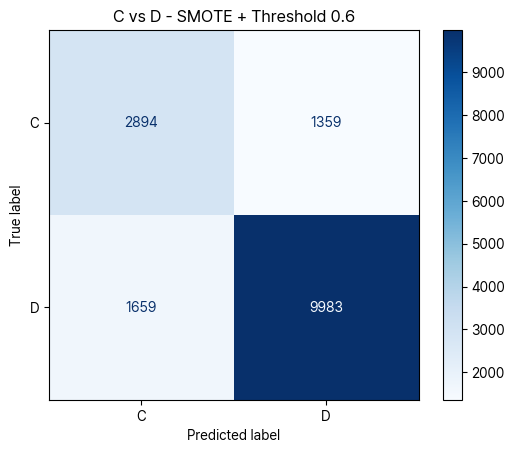

In [45]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import time

# 1. 데이터 구성 (C vs D)
cd_df = df_latest[df_latest['Segment'].isin(['C', 'D'])].copy()
y_cd = cd_df['Segment'].map({'C': 0, 'D': 1})
X_cd = cd_df[top_cde + pca_cols].copy()
X_cd = X_cd.loc[:, ~X_cd.columns.duplicated()]

# 2. Train / Val 분할
X_train, X_val, y_train, y_val = train_test_split(
    X_cd, y_cd, test_size=0.2, stratify=y_cd, random_state=42
)

# 3. SMOTE 적용
print("🔄 SMOTE 적용 중...")
start = time.time()
X_train_sm, y_train_sm = SMOTE(random_state=42).fit_resample(X_train, y_train)
print(f"✅ SMOTE 완료 (소요 시간: {time.time() - start:.2f}초)")

# 4. 모델 학습
model_c_vs_d_smote_thresh = XGBClassifier(
    use_label_encoder=False,
    eval_metric="logloss",
    tree_method="hist",
    device="cuda",
    random_state=42
)

model_c_vs_d_smote_thresh.fit(X_train_sm, y_train_sm)

# 5. Threshold 0.6 적용하여 예측
proba = model_c_vs_d_smote_thresh.predict_proba(X_val)[:, 1]
y_pred = (proba > 0.6).astype(int)

# 6. 성능 평가
print("\n📊 [C vs D - SMOTE + Threshold 0.6] Classification Report")
print(classification_report(y_val, y_pred, target_names=["C", "D"]))

ConfusionMatrixDisplay.from_predictions(y_val, y_pred, display_labels=["C", "D"], cmap="Blues")
plt.title("C vs D - SMOTE + Threshold 0.6")
plt.grid(False)
plt.show()


⏳ [C vs D - 가중치 + Threshold 0.6] 시작합니다...


c:\Users\somee\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:21:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📊 [C vs D - 가중치 + Threshold 0.6] Classification Report (소요 시간: 1.27초)
              precision    recall  f1-score   support

           C       0.56      0.80      0.66      4253
           D       0.91      0.77      0.84     11642

    accuracy                           0.78     15895
   macro avg       0.74      0.79      0.75     15895
weighted avg       0.82      0.78      0.79     15895



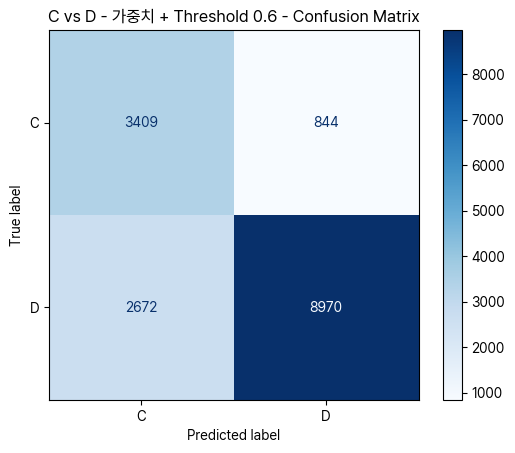


⏳ [C vs D - SMOTE + 가중치] 시작합니다...


c:\Users\somee\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:21:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📊 [C vs D - SMOTE + 가중치] Classification Report (소요 시간: 1.70초)
              precision    recall  f1-score   support

           C       0.69      0.61      0.65      4253
           D       0.86      0.90      0.88     11642

    accuracy                           0.82     15895
   macro avg       0.78      0.75      0.76     15895
weighted avg       0.82      0.82      0.82     15895



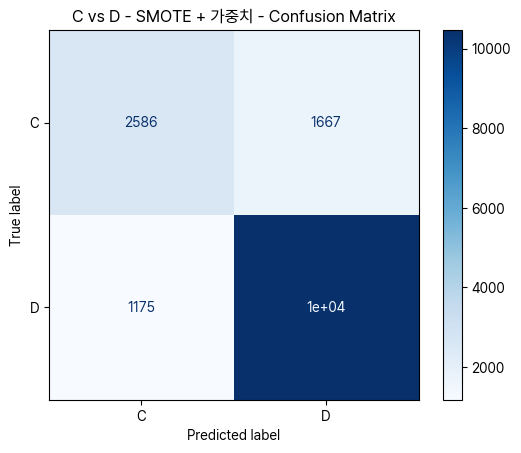


⏳ [C vs D - SMOTE + 가중치 + Threshold 0.6] 시작합니다...


c:\Users\somee\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:21:53] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📊 [C vs D - SMOTE + 가중치 + Threshold 0.6] Classification Report (소요 시간: 1.85초)
              precision    recall  f1-score   support

           C       0.64      0.68      0.66      4253
           D       0.88      0.86      0.87     11642

    accuracy                           0.81     15895
   macro avg       0.76      0.77      0.76     15895
weighted avg       0.81      0.81      0.81     15895



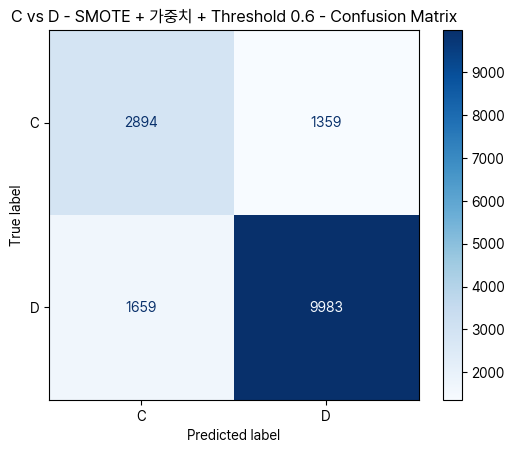

In [46]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import time

def run_combo_experiment(combo_name, smote=False, weight=False, threshold=None):
    print(f"\n⏳ [{combo_name}] 시작합니다...")
    start = time.time()

    # 1. 데이터 분할
    cd_df = df_latest[df_latest['Segment'].isin(['C', 'D'])].copy()
    y_cd = cd_df['Segment'].map({'C': 0, 'D': 1})
    X_cd = cd_df[top_cde + pca_cols].copy()
    X_cd = X_cd.loc[:, ~X_cd.columns.duplicated()]

    X_train, X_val, y_train, y_val = train_test_split(
        X_cd, y_cd, stratify=y_cd, test_size=0.2, random_state=42
    )

    # 2. SMOTE 적용
    if smote:
        X_train, y_train = SMOTE(random_state=42).fit_resample(X_train, y_train)

    # 3. 클래스 가중치 설정
    scale_pos_weight = None
    if weight:
        # D = 1, C = 0
        scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

    # 4. 모델 정의
    model = XGBClassifier(
        use_label_encoder=False,
        eval_metric="logloss",
        tree_method="hist",
        device="cuda",
        random_state=42,
        scale_pos_weight=scale_pos_weight
    )
    model.fit(X_train, y_train)

    # 5. 예측
    if threshold:
        proba = model.predict_proba(X_val)[:, 1]
        y_pred = (proba > threshold).astype(int)
    else:
        y_pred = model.predict(X_val)

    # 6. 결과 출력
    elapsed = time.time() - start
    print(f"\n📊 [{combo_name}] Classification Report (소요 시간: {elapsed:.2f}초)")
    print(classification_report(y_val, y_pred, target_names=["C", "D"]))

    ConfusionMatrixDisplay.from_predictions(y_val, y_pred, display_labels=["C", "D"], cmap="Blues")
    plt.title(f"{combo_name} - Confusion Matrix")
    plt.grid(False)
    plt.show()

    return model

# [B] 가중치 + Threshold 0.6
model_b = run_combo_experiment("C vs D - 가중치 + Threshold 0.6", smote=False, weight=True, threshold=0.6)

# [C] SMOTE + 가중치
model_c = run_combo_experiment("C vs D - SMOTE + 가중치", smote=True, weight=True, threshold=None)

# [D] SMOTE + 가중치 + Threshold 0.6
model_d = run_combo_experiment("C vs D - SMOTE + 가중치 + Threshold 0.6", smote=True, weight=True, threshold=0.6)


| 조합 전략                           | C Precision | C Recall | D Precision | D Recall | Accuracy | Macro F1 | 특이사항        |
| ------------------------------- | ----------- | -------- | ----------- | -------- | -------- | -------- | ----------- |
| 기본 모델                           | 0.77        | 0.62     | 0.87        | 0.93     | 0.85     | 0.80     | baseline    |
| 가중치 적용                          | 0.64        | 0.80     | 0.92        | 0.84     | 0.83     | 0.80     | C recall ↑  |
| SMOTE 적용                        | 0.72        | 0.69     | 0.89        | 0.90     | 0.84     | 0.80     |             |
| Threshold 0.6만 적용               | 0.72        | 0.70     | 0.89        | 0.90     | 0.85     | 0.80     |             |
| SMOTE + Threshold 0.6 (A)       | 0.64        | 0.68     | 0.88        | 0.86     | 0.81     | 0.76     |             |
| SMOTE + 가중치 (C)                 | 0.69        | 0.61     | 0.86        | 0.90     | 0.82     | 0.76     |             |
| **가중치 + Threshold 0.6 (B)**     | **0.56**    | **0.80** | **0.91**    | **0.77** | **0.78** | **0.75** | C recall ↑↑ |
| SMOTE + 가중치 + Threshold 0.6 (D) | 0.64        | 0.68     | 0.88        | 0.86     | 0.81     | 0.76     |             |


### 가중치 적용 기준 C / D ROC

In [48]:
from xgboost import XGBClassifier
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc
)
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import time

def train_and_evaluate_c_vs_d(X, y, title="Model", threshold=None, sample_strategy=None, weight=False):
    from sklearn.model_selection import train_test_split

    X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
    
    # 리샘플링
    if sample_strategy == "SMOTE":
        X_train, y_train = SMOTE(random_state=42).fit_resample(X_train, y_train)

    # 가중치
    scale_pos_weight = None
    if weight:
        scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

    model = XGBClassifier(
        tree_method="hist", device="cuda",
        use_label_encoder=False, eval_metric="logloss",
        random_state=42,
        scale_pos_weight=scale_pos_weight
    )

    start = time.time()
    model.fit(X_train, y_train)
    elapsed = time.time() - start

    # 확률 예측
    proba = model.predict_proba(X_val)[:, 1]
    
    # threshold 적용 여부
    if threshold:
        y_pred = (proba > threshold).astype(int)
    else:
        y_pred = model.predict(X_val)

    # 결과 출력
    print(f"\n📌 [{title}] (소요 시간: {elapsed:.2f}초)")
    print(classification_report(y_val, y_pred, target_names=["C", "D"]))

    # Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)
    ConfusionMatrixDisplay(cm, display_labels=["C", "D"]).plot(cmap="Blues")
    plt.title(f"{title} - Confusion Matrix")
    plt.show()

    # 🔵 ROC Curve
    fpr, tpr, _ = roc_curve(y_val, proba)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(7, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title(f'{title} - ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

    return model


c:\Users\somee\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:33:01] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



📌 [SMOTE + Threshold 0.6] (소요 시간: 0.88초)
              precision    recall  f1-score   support

           C       0.64      0.68      0.66      4253
           D       0.88      0.86      0.87     11642

    accuracy                           0.81     15895
   macro avg       0.76      0.77      0.76     15895
weighted avg       0.81      0.81      0.81     15895



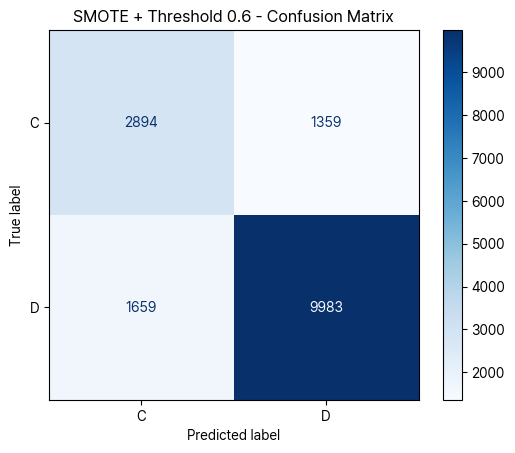

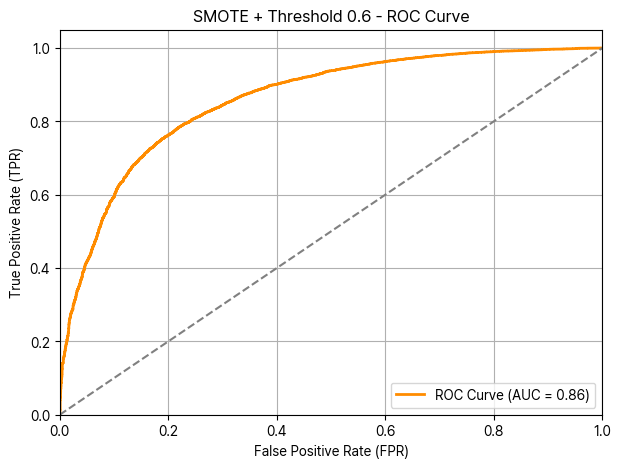

In [51]:
model = train_and_evaluate_c_vs_d(
    X_cd, y_cd,
    title="SMOTE + Threshold 0.6",
    threshold=0.6,
    sample_strategy="SMOTE",
    weight=False
)


In [52]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, f1_score

def plot_threshold_metrics(y_true, y_probs, title="Threshold vs Metrics"):
    precision, recall, thresholds = precision_recall_curve(y_true, y_probs)
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6)  # 작은 값 더해 나눗셈 방지

    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precision[:-1], label="Precision", color="blue")
    plt.plot(thresholds, recall[:-1], label="Recall", color="green")
    plt.plot(thresholds, f1_scores[:-1], label="F1 Score", color="orange")
    plt.axvline(x=0.6, color='gray', linestyle='--', label="Threshold = 0.6")

    plt.xlabel("Threshold")
    plt.ylabel("Metric Score")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

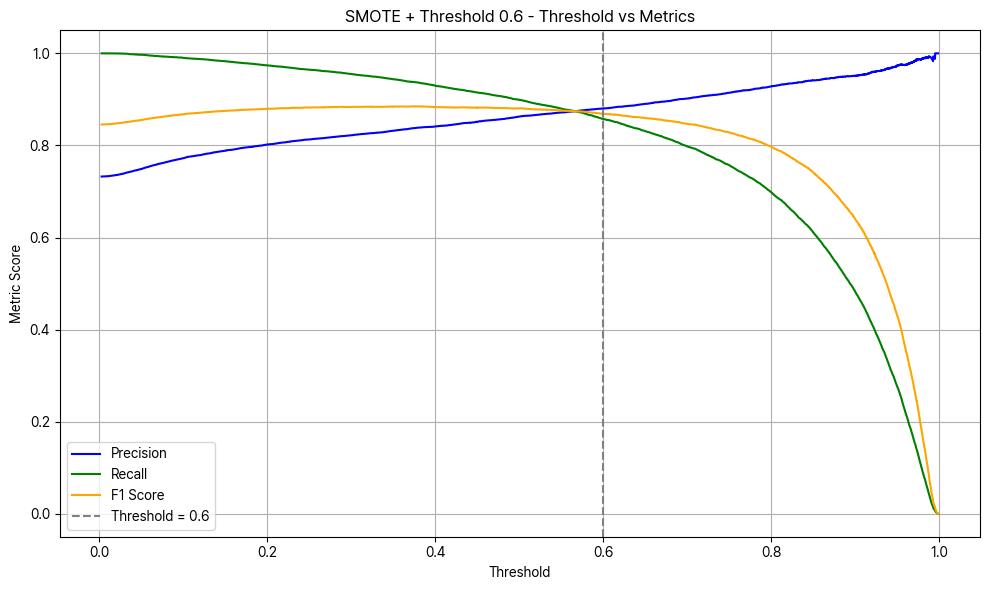

In [53]:
# 모델 예측 확률과 실제값을 준비
proba = model.predict_proba(X_val)[:, 1]  # C일 확률
plot_threshold_metrics(y_val, proba, title="SMOTE + Threshold 0.6 - Threshold vs Metrics")